# Objectives
 - How many ER visits in Ontario weren't urgent?
 - How many of those visits could have been accommodated by Walk-In Clinics or Urgent Care?

# Analysis

In [372]:
# Dependencies
%pip install openpyxl
%pip install matplotlib

# Imports
import pandas as pd
pd.set_option("future.no_silent_downcasting", True)
import matplotlib.pyplot as plt
import numpy as np

# Types
from numpy import ndarray, float64

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Total ER Visits:  15498402
Total Ontario ER Visits:  6430184
Total Ontario Share of Visits: % 41.48933548116767


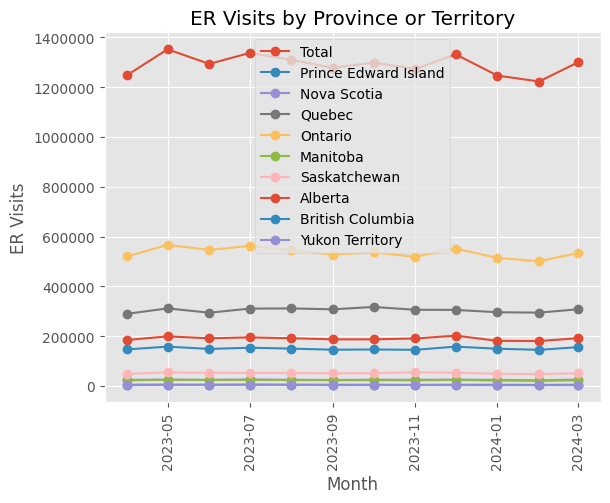

In [373]:
# BLOCKER: https://data.ontario.ca/dataset/emergency-room-national-ambulatory-reporting-system-initiative-erni
# REFERENCE: https://www.cihi.ca/en/nacrs-emergency-department-visits-and-lengths-of-stay

# Aggregate Table
# SOURCE: https://www.cihi.ca/sites/default/files/document/emergency-department-visits-apr-2023-mar-2024-data-tables-en.xlsx
er_data: pd.ExcelFile = pd.ExcelFile("../source_data/emergency-department-visits-apr-2023-mar-2024-data-tables-en.xlsx")
er_data_visits: pd.DataFrame = er_data.parse("2 ED visits, month, age and sex", skiprows=4, skipfooter=9)

# Scrub Data
er_data_visits["Month"] = pd.to_datetime(er_data_visits["Month"], format="%B %Y")
er_data_visits.set_index("Month", inplace=True)
er_data_visits.rename(
    columns={
        "Province/territory*": "Province or Territory",
        "\n0–4\nAge group (years)": "Age 0-4",
        "\n5–19\nAge group (years)": "Age 5-19",
        "\n20–64\nAge group (years)": "Age 20-64",
        "\n65+\nAge group (years)": "Age 65+",
        "\nAll\nAge group (years)": "All Ages"
    },
    inplace=True
)
# Fetched Unique Names to specify 'bad_names': er_data_visits["Province or Territory"].unique().tolist()
bad_names: list[str] = [
    "P.E.I.†",
    "N.S.†",
    "Que.",
    "Ont.",
    "Man.†",
    "Sask.†",
    "Alta.",
    "B.C.†",
    "Y.T."
]
good_names: list[str] = [
    "Prince Edward Island",
    "Nova Scotia",
    "Quebec",
    "Ontario",
    "Manitoba",
    "Saskatchewan",
    "Alberta",
    "British Columbia",
    "Yukon Territory"
]
er_data_visits["Province or Territory"] = er_data_visits["Province or Territory"].replace(bad_names, good_names)

# PROBLEM: The data provided is 2023-2024, however the Supplemental Information Table is 2003-2022
#          which contains our 'Visit Disposition'
#          Therefore, we cannot reliably correlate ER visits in Ontario against the National ER Data
#          present in the 'Supplemental Information' talble
# SOLUTION: What we can do is take the average percentage of ER visits for Ontario against National
#           and make a statistical guess based on the sum of 'Total' where 'Sex' == 'All' from April
#           2023 through March 2024

# Plot Numbers
for province_territory in er_data_visits["Province or Territory"].unique():
    series: pd.Series = er_data_visits.loc[(er_data_visits["Sex"] == "All") & (er_data_visits["Province or Territory"] == province_territory)]["All Ages"]

    # Plot
    plt.style.use("ggplot")
    plt.title("ER Visits by Province or Territory")
    plt.plot(series, label=province_territory, marker='o')
    plt.xlabel("Month")
    plt.xticks(rotation=90)
    plt.ylabel("ER Visits")
    plt.ticklabel_format(style="plain", axis="y")
    plt.legend()
    plt.grid(True)

# Calculate Average
total_visits: int = er_data_visits.loc[(er_data_visits["Sex"] == "All") & (er_data_visits["Province or Territory"] == "Total")]["All Ages"].sum()
ontario_visits: int = er_data_visits.loc[(er_data_visits["Sex"] == "All") & (er_data_visits["Province or Territory"] == "Ontario")]["All Ages"].sum()
ontario_share_of_visits: float = ontario_visits / total_visits * 100
print("Total ER Visits: ", total_visits)
print("Total Ontario ER Visits: ", ontario_visits)
print("Total Ontario Share of Visits: %", ontario_share_of_visits)

In [ ]:
# Provisional Data
# SOURCE: https://www.cihi.ca/sites/default/files/document/emergency-department-visits-apr-sep-2024-provisional-data-tables-en.xlsx
er_data_supplementary: pd.ExcelFile = pd.ExcelFile("../source_data/emergency-department-visits-2003-2021-supplementary-data-tables-en.xlsx")
er_data_supplementary_visits: pd.DataFrame = er_data_supplementary.parse("1 ED visits", skiprows=4, skipfooter=12)
er_data_supplementary_disposition: pd.DataFrame = er_data_supplementary.parse("2 Visit disposition", skiprows=4, skipfooter=12)
er_data_supplementary_level: pd.DataFrame = er_data_supplementary.parse("3 Triage level", skiprows=4, skipfooter=11)
er_data_supplementary_problem: pd.DataFrame = er_data_supplementary.parse("4 Main problem", skiprows=4, skipfooter=13)
er_data_supplementary_demographics: pd.DataFrame = er_data_supplementary.parse("5 Age and sex", skiprows=4, skipfooter=11)

# Scrub Data
column_rename: dict = {
    "Triage level": "Triage Level",
    "Visit disposition": "Visit Disposition",
    "Main problem": "Main Problem",
    "Number of \nED visits": "Number of ED Visits",
    "Median length of stay \n(minutes)": "Median Length of Stay (minutes)",
    "Median length of stay (minutes)": "Median Length of Stay (minutes)"
}
er_data_supplementary_visits.set_index("Fiscal year", inplace=True)
er_data_supplementary_visits.sort_index(inplace=True)
er_data_supplementary_visits.rename(columns=column_rename, inplace=True)
# NOTE: Non-Numeric Value Definitions
# n/r: Due to privacy and confidentiality concerns, and to minimize the risk of residual disclosure, volumes of fewer than 5 visits have been suppressed in the cells and removed from total visit counts.
# n/d: No data.
er_data_supplementary_visits.replace(
    to_replace=[ "n/r", "n/d" ],
    value=[ 0, 0 ],
    inplace=True
)
er_data_supplementary_disposition.set_index("Fiscal year", inplace=True)
er_data_supplementary_disposition.sort_index(inplace=True)
er_data_supplementary_disposition.rename(columns=column_rename, inplace=True)
er_data_supplementary_level.set_index("Fiscal year", inplace=True)
er_data_supplementary_level.sort_index(inplace=True)
er_data_supplementary_level.rename(columns=column_rename, inplace=True)
er_data_supplementary_problem.set_index("Fiscal year", inplace=True)
er_data_supplementary_problem.sort_index(inplace=True)
er_data_supplementary_problem.rename(columns=column_rename, inplace=True)
er_data_supplementary_demographics.set_index("Fiscal year", inplace=True)
er_data_supplementary_demographics.sort_index(inplace=True)
er_data_supplementary_demographics.rename(columns=column_rename, inplace=True)

## ER Visits

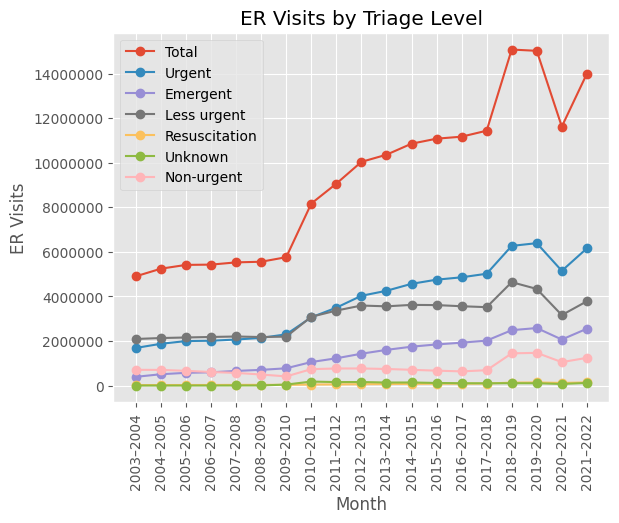

In [67]:
# Triage Level
for level in er_data_supplementary_visits["Triage Level"].unique():
    series: pd.Series = er_data_supplementary_visits.loc[(er_data_supplementary_visits["Visit Disposition"] == "Total") & (er_data_supplementary_visits["Main Problem"] == "Any") & (er_data_supplementary_visits["Triage Level"] == level)]["Number of ED Visits"]

    # Plot
    plt.style.use("ggplot")
    plt.title("ER Visits by Triage Level")
    plt.plot(series, label=level, marker='o')
    plt.xlabel("Month")
    plt.xticks(rotation=90)
    plt.ylabel("ER Visits")
    plt.ticklabel_format(style="plain", axis="y")
    plt.legend()
    plt.grid(True)

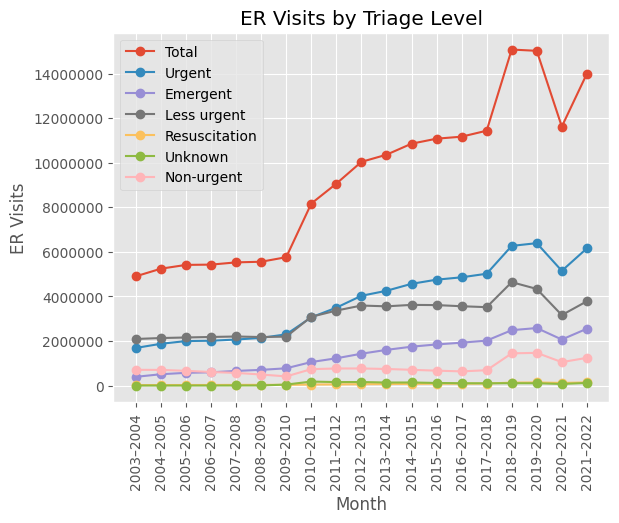

In [68]:
# Triage Level
for level in er_data_supplementary_visits["Triage Level"].unique():
    series: pd.Series = er_data_supplementary_visits.loc[(er_data_supplementary_visits["Visit Disposition"] == "Total") & (er_data_supplementary_visits["Main Problem"] == "Any") & (er_data_supplementary_visits["Triage Level"] == level)]["Number of ED Visits"]

    # Plot
    plt.style.use("ggplot")
    plt.title("ER Visits by Triage Level")
    plt.plot(series, label=level, marker='o')
    plt.xlabel("Month")
    plt.xticks(rotation=90)
    plt.ylabel("ER Visits")
    plt.ticklabel_format(style="plain", axis="y")
    plt.legend()
    plt.grid(True)

Total Number of Visits:  175788033
Number of Visits where Patient was 'Not seen or left':  8498370
Percentage: % 0.04834441716518894


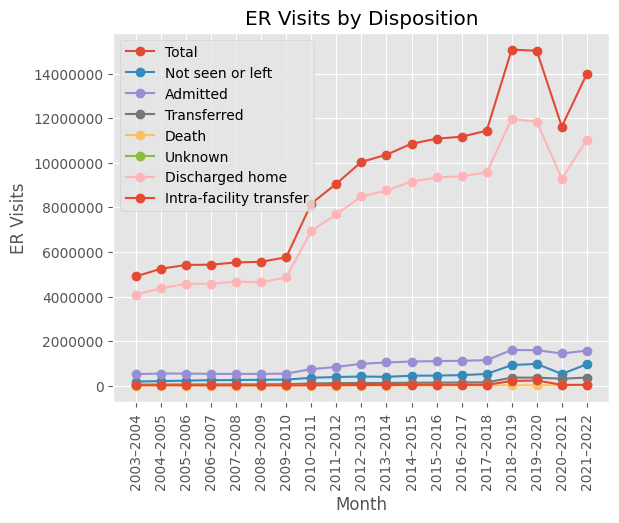

In [371]:
# Visit Disposition
for disposition in er_data_supplementary_visits["Visit Disposition"].unique():
    series: pd.Series = er_data_supplementary_visits.loc[(er_data_supplementary_visits["Triage Level"] == "Total") & (er_data_supplementary_visits["Main Problem"] == "Any") & (er_data_supplementary_visits["Visit Disposition"] == disposition)]["Number of ED Visits"]

    # Plot
    plt.style.use("ggplot")
    plt.title("ER Visits by Disposition")
    plt.plot(series, label=disposition, marker='o')
    plt.xlabel("Month")
    plt.xticks(rotation=90)
    plt.ylabel("ER Visits")
    plt.ticklabel_format(style="plain", axis="y")
    plt.legend()
    plt.grid(True)

total_visits: int = er_data_supplementary_visits.loc[
    (er_data_supplementary_visits["Triage Level"] == "Total") &
    (er_data_supplementary_visits["Visit Disposition"] == "Total") &
    (er_data_supplementary_visits["Main Problem"] == "Any")
]["Number of ED Visits"].sum()
unseen_left_visits: int = er_data_supplementary_visits.loc[
    (er_data_supplementary_visits["Triage Level"] == "Total") &
    (er_data_supplementary_visits["Visit Disposition"] == "Not seen or left") &
    (er_data_supplementary_visits["Main Problem"] == "Any")
]["Number of ED Visits"].sum()

print("Total Number of Visits: ", total_visits)
print("Number of Visits where Patient was 'Not seen or left': ", unseen_left_visits )
print("Percentage: %", unseen_left_visits / total_visits)

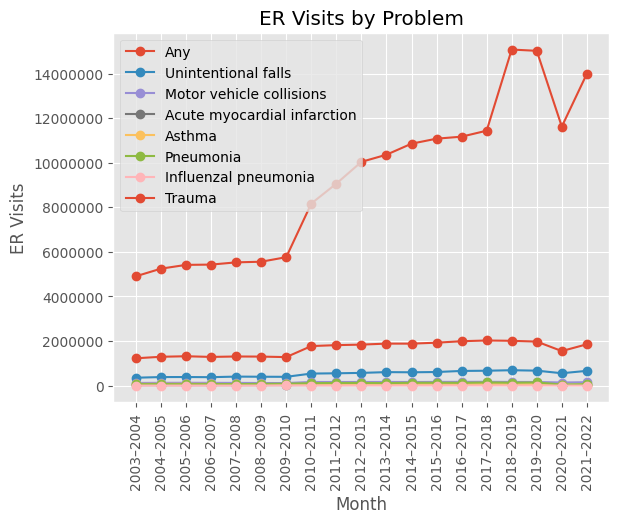

In [334]:
### ER Visits
# Main Problem
for problem in er_data_supplementary_visits["Main Problem"].unique():
    series: pd.Series = er_data_supplementary_visits.loc[(er_data_supplementary_visits["Triage Level"] == "Total") & (er_data_supplementary_visits["Visit Disposition"] == "Total") & (er_data_supplementary_visits["Main Problem"] == problem)]["Number of ED Visits"]

    # Plot
    plt.style.use("ggplot")
    plt.title("ER Visits by Problem")
    plt.plot(series, label=problem, marker='o')
    plt.xlabel("Month")
    plt.xticks(rotation=90)
    plt.ylabel("ER Visits")
    plt.ticklabel_format(style="plain", axis="y")
    plt.legend()
    plt.grid(True)

*NOTE*: Observed that the 'Any' of 'Main Problem' doesn't stack up to the sum of 'Main Problem' categories

The 'Main Problem' where == 'Influenzal pneumonia'or 'Asthma' is marked 'n/r' due to
"Privacy and Confidentiality" however this statistic represents a majority of the Visits by Problem

Why would this data be hidden when it represents the majority?

The definition from the government is: "volumes of fewer than 5 visits have been suppressed in the cells and removed from total visit counts."
however, this cannot be true with numbers with this large of a gap representation.

In [366]:
# NOTE: Let's extrapolate the value where there is only one 'Main Problem' that has a value of 'n/r'
#       We will do this by iterating over the pd.DataFrame and will determine where 'problem' == 0 and has one instance

# Reset Data so that we can differentiate between 'n/r' and 'n/d'
er_data_supplementary_visits: pd.DataFrame = er_data_supplementary.parse("1 ED visits", skiprows=4, skipfooter=12)
er_data_supplementary_visits.set_index("Fiscal year", inplace=True)
er_data_supplementary_visits.sort_index(inplace=True)
er_data_supplementary_visits.rename(columns=column_rename, inplace=True)

non_recorded_data: pd.DataFrame = er_data_supplementary_visits.loc[er_data_supplementary_visits["Number of ED Visits"] == "n/r"]
print("Unique 'Main Problem' which are 'n/r' in Data: ", non_recorded_data["Main Problem"].unique())
print("Unique 'Main Problem' which are 'n/r' in Data from 'Total' Triage Level: ", non_recorded_data.loc[non_recorded_data["Triage Level"] == "Total"]["Main Problem"].unique())

Unique 'Main Problem' which are 'n/r' in Data:  ['Asthma' 'Influenzal pneumonia' 'Pneumonia' 'Acute myocardial infarction'
 'Unintentional falls' 'Motor vehicle collisions' 'Trauma']
Unique 'Main Problem' which are 'n/r' in Data from 'Total' Triage Level:  ['Influenzal pneumonia' 'Asthma']


This is the moment that I no longer trust this data, because how could 'Acute myocardial infarction', 'Unintentional falls', 'Motor vehicle collisions', and 'Trauma' be missing from the 'Total' of 'Triage Level'?

In [367]:
# Reset Index so that we can get a row index for Value Patching
er_data_supplementary_visits.reset_index(names=[ "Fiscal Year" ], inplace=True)
er_data_supplementary_visits.index = pd.RangeIndex(start=0, stop=er_data_supplementary_visits.shape[0], step=1)
er_data_supplementary_visits.insert(0, "Has Variance", False)

print("DATAFRAME SIZE BEFORE PATCH: ", er_data_supplementary_visits.shape[0])
print("BEFORE PATCH: Number of Rows with 'n/d': ", er_data_supplementary_visits.loc[er_data_supplementary_visits["Number of ED Visits"] == "n/d"].shape[0])
print("BEFORE PATCH: Number of Rows with 'n/r': ", er_data_supplementary_visits.loc[er_data_supplementary_visits["Number of ED Visits"] == "n/r"].shape[0])

# NOTE: Iterate over data so that we may fill in the 'n/r' value where appropriate
#       'appropriate' == when there is only one 'Main Problem' with a stat value of 'n/r',
#       since doing this for multiple rows on a given group would be a guess ultimately
column_index: int = er_data_supplementary_visits.columns.get_loc("Number of ED Visits")
triage_total_variance: int = 0
disposition_total_variance: int = 0
for fiscal_year in er_data_supplementary_visits["Fiscal Year"].unique():
    for level in er_data_supplementary_visits.loc[(er_data_supplementary_visits["Fiscal Year"] == fiscal_year)]["Triage Level"].unique():
        for disposition in er_data_supplementary_visits.loc[(er_data_supplementary_visits["Fiscal Year"] == fiscal_year) & (er_data_supplementary_visits["Triage Level"] == level)]["Visit Disposition"].unique():
            visits_any: pd.DataFrame = er_data_supplementary_visits.loc[(er_data_supplementary_visits["Fiscal Year"] == fiscal_year) & (er_data_supplementary_visits["Triage Level"] == level) & (er_data_supplementary_visits["Visit Disposition"] == disposition) & (er_data_supplementary_visits["Main Problem"] == "Any")]
            other_visits: pd.DataFrame = er_data_supplementary_visits.loc[(er_data_supplementary_visits["Fiscal Year"] == fiscal_year) & (er_data_supplementary_visits["Triage Level"] == level) & (er_data_supplementary_visits["Visit Disposition"] == disposition) & (er_data_supplementary_visits["Main Problem"] != "Any")]

            non_recorded_visits: pd.DataFrame = other_visits.loc[other_visits["Number of ED Visits"] == "n/r"]

            if non_recorded_visits.shape[0] == 1:
                total_visits: int = visits_any["Number of ED Visits"].sum()
                sum_other_visits: int = other_visits.loc[(other_visits["Number of ED Visits"] != "n/r") & (other_visits["Number of ED Visits"] != "n/d")]["Number of ED Visits"].sum()
                variance: int = total_visits - sum_other_visits
                problem: str = non_recorded_visits["Main Problem"].values[0]

                # print("-- Variance Detected in Field '", problem, "' --")
                # print("Total Visits in ", fiscal_year, level, disposition, ": ", total_visits)
                # print("Sum of All Visits: ", sum_other_visits)
                # print("Variance: ", variance)

                if level == "Total":
                    triage_total_variance += variance
                if disposition == "Total":
                    disposition_total_variance += variance

                if level == "Total" and disposition == "Total":
                    print("Hit!")

                sum_before: int = er_data_supplementary_visits.loc[(er_data_supplementary_visits["Fiscal Year"] == fiscal_year) & (er_data_supplementary_visits["Triage Level"] == level) & (er_data_supplementary_visits["Visit Disposition"] == disposition) & (er_data_supplementary_visits["Main Problem"] != "Any") & (er_data_supplementary_visits["Number of ED Visits"] != "n/r") & (er_data_supplementary_visits["Number of ED Visits"] != "n/d")]["Number of ED Visits"].sum()
                print("Before Patch on ", fiscal_year, level, problem, ": ", sum_before)

                # Apply Variance to Patched DataFrame
                row_index: pd.Index = er_data_supplementary_visits[
                    (er_data_supplementary_visits["Fiscal Year"] == fiscal_year) &
                    (er_data_supplementary_visits["Triage Level"] == level) &
                    (er_data_supplementary_visits["Visit Disposition"] == disposition) &
                    (er_data_supplementary_visits["Main Problem"] == problem) &
                    (er_data_supplementary_visits["Number of ED Visits"] == "n/r")
                ].index[0]
                er_data_supplementary_visits.at[row_index, "Number of ED Visits"] = variance
                er_data_supplementary_visits.at[row_index, "Has Variance"] = True

                # Update Totals
                total_row_index: pd.Index = er_data_supplementary_visits[
                    (er_data_supplementary_visits["Fiscal Year"] == fiscal_year) &
                    (er_data_supplementary_visits["Triage Level"] == "Total") &
                    (er_data_supplementary_visits["Visit Disposition"] == "Total") &
                    (er_data_supplementary_visits["Main Problem"] == problem)
                ].index[0]
                er_data_supplementary_visits.at[total_row_index, "Number of ED Visits"] = sum_before + variance

                sum_after: int = er_data_supplementary_visits.loc[(er_data_supplementary_visits["Fiscal Year"] == fiscal_year) & (er_data_supplementary_visits["Triage Level"] == level) & (er_data_supplementary_visits["Visit Disposition"] == disposition) & (er_data_supplementary_visits["Main Problem"] != "Any") & (er_data_supplementary_visits["Number of ED Visits"] != "n/r") & (er_data_supplementary_visits["Number of ED Visits"] != "n/d")]["Number of ED Visits"].sum()
                print("After Patch on ", fiscal_year, level, problem, ": ", sum_after)

                # if sum_before != sum_after:
                #     raise Exception("Value Applied was not Saved!")
            else:
                # Skip multiple 'n/r' values in a grouping, as this would be guessing
                continue

print("AFTER PATCH: Number of rows with 'n/r': ", er_data_supplementary_visits.loc[er_data_supplementary_visits["Number of ED Visits"] == "n/r"].shape[0])
print("Variances found in Triage Total: ", triage_total_variance)
print("Variances found in Disposition Total: ", disposition_total_variance)

# Apply Patch
er_data_supplementary_visits = er_data_supplementary_visits.loc[(er_data_supplementary_visits["Number of ED Visits"] != "n/r") & (er_data_supplementary_visits["Number of ED Visits"] != "n/d")]
print("DATAFRAME SIZE AFTER PATCH: ", er_data_supplementary_visits.shape[0])
# er_data_supplementary_visits["Number of ED Visits"] = pd.to_numeric(er_data_supplementary_visits["Number of ED Visits"], errors="raise")

# Set Index back to 'Fiscal Year' for Plotting
er_data_supplementary_visits.set_index("Fiscal Year", inplace=True)

DATAFRAME SIZE BEFORE PATCH:  8512
BEFORE PATCH: Number of Rows with 'n/d':  1883
BEFORE PATCH: Number of Rows with 'n/r':  577
Before Patch on  2003–2004 Total Influenzal pneumonia :  42300
After Patch on  2003–2004 Total Influenzal pneumonia :  184760
Before Patch on  2003–2004 Total Influenzal pneumonia :  14597
After Patch on  2003–2004 Total Influenzal pneumonia :  44610
Before Patch on  2003–2004 Total Influenzal pneumonia :  19927
After Patch on  2003–2004 Total Influenzal pneumonia :  42385
Before Patch on  2003–2004 Urgent Influenzal pneumonia :  8721
After Patch on  2003–2004 Urgent Influenzal pneumonia :  59448
Before Patch on  2003–2004 Urgent Asthma :  122
After Patch on  2003–2004 Urgent Asthma :  487
Before Patch on  2003–2004 Urgent Influenzal pneumonia :  4816
After Patch on  2003–2004 Urgent Influenzal pneumonia :  12486
Before Patch on  2003–2004 Emergent Influenzal pneumonia :  63184
After Patch on  2003–2004 Emergent Influenzal pneumonia :  232137
Before Patch on  

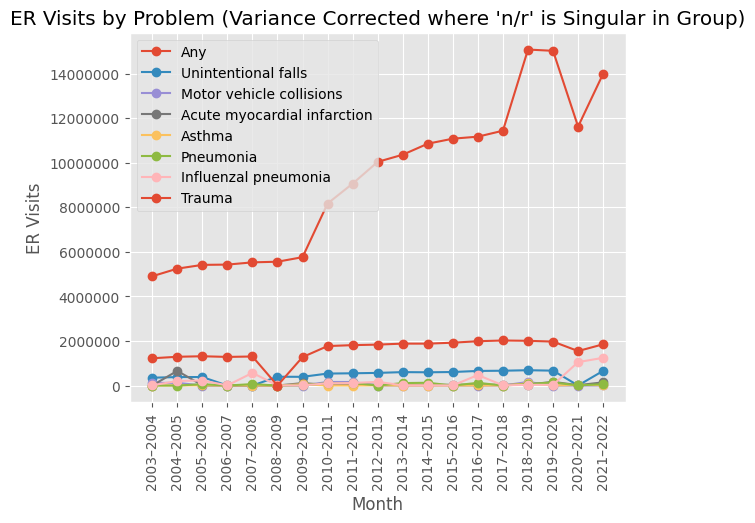

In [368]:
# Main Problem
for problem in er_data_supplementary_visits["Main Problem"].unique():
    series: pd.Series = er_data_supplementary_visits.loc[
        (er_data_supplementary_visits["Triage Level"] == "Total") &
        (er_data_supplementary_visits["Visit Disposition"] == "Total") &
        (er_data_supplementary_visits["Main Problem"] == problem)
    ]["Number of ED Visits"]

    # Plot
    plt.style.use("ggplot")
    plt.title("ER Visits by Problem (Variance Corrected where 'n/r' is Singular in Group)")
    plt.plot(series, label=problem, marker='o')
    plt.xlabel("Month")
    plt.xticks(rotation=90)
    plt.ylabel("ER Visits")
    plt.ticklabel_format(style="plain", axis="y")
    plt.legend()
    plt.grid(True)

# Conclusion
### Challenges
At first I had experienced regret in choosing this data source for the group assignment, and was then surprised to find that there are inconsistencies in the data and values intentionally missing for "privacy" reasons which respresent a substantial number of ER Visits across Canada let alone Ontario.

The abillity to find quality information about public hospital use is restricted under government mandate. https://data.ontario.ca/dataset/emergency-room-national-ambulatory-reporting-system-initiative-erni indicates simply: "This data is not and will not be made available. The data was reviewed and cannot be released to the public because of reasons outlined by the Digital and Data Directive."

Therefore, unfortunately we had no access to qualitative data other than summary information discovered.

### Observations
Calculating the aggregated number of visits by province, we have established that Ontario appears to have a 41.49% share of the total number.

0.048% of ER Visits where the patient was 'Not seen or left' could have been avoided, were it an emergency the patient would have stayed on-site. This number represents 8,498,370 hospital visits nation-wide, which would be an assumed 3,525,974 visits in Ontario alone.

5,460,0440 ER Visits have numbers intentionally left out for "privacy" reasons even though this data is aggregated which I find both interesting and frustrating.

The number of 'Infuenzal Pneumonia' cases had an uptick in 2007-2008, 2016-2017, and 2020-2022.

Could this be because of:
 - The H5N1 global spread in 2007?
 - An unknown uptick in 2016-2017?
 - COVID in 2020?

### Follow-Up Questions
It is possible to find interesting information in summarised data, and while having deeply detailed data would have been advantageous there were interesting findings from this exercise. A news agency for example could deep dive into summary data such as this would result in some interesting questions for both the Government and the Public:
 1. Why are numbers redacted when it is within summary data? How does that protect privacy when the data is aggregated?
 2. What is the dollar value associated with an ER visit that was unnecessary?
 3. Would better public education have an impact on the number of unnecessary ER visits?

# References (IEEE)
1. “NCARS Emergency Department Visits and Lengths of Stay | CIHI”. https://www.cihi.ca/en/nacrs-emergency-department-visits-and-lengths-of-stay (Accessed: April 12 2025).
2. “Emergency Room National Ambulatory Reporting System Initiative (ERNI)”. https://data.ontario.ca/dataset/emergency-room-national-ambulatory-reporting-system-initiative-erni (Accessed: April 12 2025).